# Drivers of Density Group
OOI Data Labs Workshop - August 2019

Revised Feb 10, 2020

**Working Title**: Drivers of Seawater Density

**Short Description**: Observe how temperature, salinity influence density at three locations.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet

* **Instruments:** 
  * CE06ISSM-RID16-03-CTDBPC000 - Washington Inshore Surface Mooring (7m)
  * GP03FLMA-RIM01-02-CTDMOG040 - Station Papa Flanking Mooring A (30m)
  * GI03FLMA-RIM01-02-CTDMOG040 - Irminger Sea Flanking Mooring A (30m)
* **Time range:** 
  * First draft: 2016-07-01 00:00:00 to 2017-02-01 00:00:00
  * Updated: 2018-07-01 00:00:00 to 2019-02-01 00:00:00

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
# request_data('CE06ISSM-RID16-03-CTDBPC000','recovered_host','ctdbp_cdef_dcl_instrument_recovered',
#              '2018-07-01T00:00:00.000Z','2019-02-01T00:00:00.000Z')
# request_data('GI03FLMA-RIM01-02-CTDMOG040','recovered_inst','ctdmo_ghqr_instrument_recovered',
#              '2018-07-01T00:00:00.000Z','2019-02-01T00:00:00.000Z')
# request_data('GP03FLMA-RIM01-02-CTDMOG040','recovered_inst','ctdmo_ghqr_instrument_recovered',
#              '2018-07-01T00:00:00.000Z','2019-02-01T00:00:00.000Z')
# request_data('CE01ISSM-RID16-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2018-07-01T00:00:00.000Z','2019-02-01T00:00:00.000Z')
# request_data('CP04OSSM-RID27-03-CTDBPC000','telemetered','ctdbp_cdef_dcl_instrument',
#              '2018-07-01T00:00:00.000Z','2019-02-01T00:00:00.000Z')


## 2. Load Data Files

In [0]:
url_ce06 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191218T185018788Z-CE06ISSM-RID16-03-CTDBPC000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/catalog.html'
url_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191218T185035986Z-GI03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_gp = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191218T185049666Z-GP03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ce01 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191220T150334271Z-CE01ISSM-RID16-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'
url_cp04 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191220T144211265Z-CP04OSSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  selected_datasets = sorted(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
# Load Data
data_ce01 = get_data(url_ce01)
data_gi = get_data(url_gi)
data_gp = get_data(url_gp)
data_cp04 = get_data(url_cp04)


In [0]:
# Remove Outliers
data_gp['practical_salinity'] = data_gp['practical_salinity'].where(reject_outliers(data_gp['practical_salinity']))
data_gp['density'] = data_gp['density'].where(reject_outliers(data_gp['density']))


## Plot the Data

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


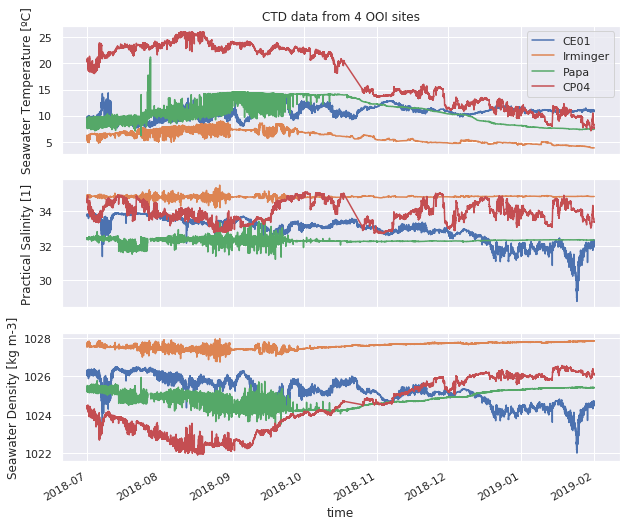

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,8))
data_ce01.ctdbp_seawater_temperature.plot(ax=ax1,label='CE01')
data_gi.ctdmo_seawater_temperature.plot(ax=ax1,label='Irminger')
data_gp.ctdmo_seawater_temperature.plot(ax=ax1,label='Papa')
data_cp04.temp.plot(ax=ax1,label='CP04')

# data_ce.practical_salinity.plot(ax=ax2)
data_ce01.practical_salinity.plot(ax=ax2,label='Endurance 01')
data_gi.practical_salinity.plot(ax=ax2)
data_gp.practical_salinity.plot(ax=ax2)
data_cp04.practical_salinity.plot(ax=ax2)

# data_ce.density.plot(ax=ax3)
data_ce01.density.plot(ax=ax3,label='Endurance 01')
data_gi.density.plot(ax=ax3)
data_gp.density.plot(ax=ax3)
data_cp04.density.plot(ax=ax3)

ax1.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax1.set_title('CTD data from 4 OOI sites');

fig.savefig('ctd_data.png')

## Average and Merge

In [10]:
%%time
# Subset and Average Datasets
avgint='1H'

a = data_ce01[['practical_salinity','ctdbp_seawater_temperature','ctdbp_seawater_pressure','density']].load().resample(time=avgint).mean()
b = data_gi[['practical_salinity','ctdmo_seawater_temperature','ctdmo_seawater_pressure','density']].load().resample(time=avgint).mean()
c = data_gp[['practical_salinity','ctdmo_seawater_temperature','ctdmo_seawater_pressure','density']].load().resample(time=avgint).mean()
d = data_cp04[['practical_salinity','temp','pressure','density']].load().resample(time=avgint).mean()


CPU times: user 31.6 s, sys: 967 ms, total: 32.6 s
Wall time: 32.5 s


In [11]:
# Merge the datasets
a = a.rename({'practical_salinity':'CE01 Salinity',
              'ctdbp_seawater_temperature':'CE01 Temperature',
              'ctdbp_seawater_pressure':'CE01 Pressure',
              'density':'CE01 Density'})
b = b.rename({'practical_salinity':'GI Salinity',
              'ctdmo_seawater_temperature':'GI Temperature',
              'ctdmo_seawater_pressure':'GI Pressure',
              'density':'GI Density'})
c = c.rename({'practical_salinity':'GP Salinity',
              'ctdmo_seawater_temperature':'GP Temperature',
              'ctdmo_seawater_pressure':'GP Pressure',
              'density':'GP Density'})
d = d.rename({'practical_salinity':'CP04 Salinity',
              'temp':'CP04 Temperature',
              'pressure':'CP04 Pressure',
              'density':'CP04 Density'})

data = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
data.head()

,CE01 Salinity,CE01 Temperature,CE01 Pressure,CE01 Density,GI Salinity,GI Temperature,GI Pressure,GI Density,GP Salinity,GP Temperature,GP Pressure,GP Density,CP04 Salinity,CP04 Temperature,CP04 Pressure,CP04 Density
time,,,,,,,,,,,,,,,,
2018-07-01 00:00:00,33.788763,8.892237,7.483318,1026.223307,34.833886,5.705310,40.347050,1027.646825,32.411900,8.232855,40.052755,1025.394762,34.564724,20.385206,7.277695,1024.364559
2018-07-01 01:00:00,33.793698,8.709283,7.465790,1026.256737,34.828762,5.827512,38.042649,1027.616844,32.418109,7.984896,39.900592,1025.435481,34.601171,20.630014,7.257083,1024.326720
2018-07-01 02:00:00,33.765574,9.005616,7.551592,1026.187914,34.826691,6.246711,36.208625,1027.552804,32.408347,8.839796,39.732913,1025.298152,34.677626,20.704903,7.268110,1024.364800
2018-07-01 03:00:00,33.728845,9.382999,7.488455,1026.099381,34.846543,5.986879,35.408074,1027.598418,32.438098,7.676994,39.376155,1025.492569,34.694660,20.482090,7.246140,1024.437522
2018-07-01 04:00:00,33.741743,9.252484,7.433023,1026.129519,34.856695,5.886106,35.225639,1027.618196,32.423239,8.074393,39.092450,1025.421741,34.768563,20.643913,7.263570,1024.450445


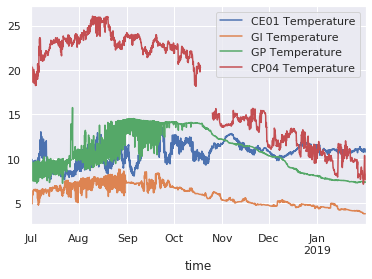

In [12]:
# Test plot
data[['CE01 Temperature','GI Temperature','GP Temperature','CP04 Temperature']].plot()

## Recalculate Density 2 Ways

Next, for this activitiy, we actually want 3 different calculations of Seawater Density.
* Temp, Salinity, Density (from instrument)
* Density holding T constant (using mean T from the record)
* Density holding S constant (using mean S from the record)

To do this we will use the [python seawater library](https://pythonhosted.org/seawater/index.html). This library may be technically out of date, as the new [GSW-Python](https://github.com/TEOS-10/GSW-Python) library follows the TEOS-10 standard, but the differences are probably very minor for the purposes of this activity.

In [13]:
! pip install seawater
import seawater as sw

In [14]:
for site in ['CE01','GI','GP','CP04']:
  print('Mean Salinity at %s: %f'%(site,data[site+' Salinity'].mean()))
  print('Mean Temperature at %s: %f'%(site,data[site+' Temperature'].mean()))
  print('Mean Pressure at %s: %f'%(site,data[site+' Pressure'].mean()))

Mean Salinity at CE01: 32.899737
Mean Temperature at CE01: 10.709093
Mean Pressure at CE01: 7.436673
Mean Salinity at GI: 34.829704
Mean Temperature at GI: 5.964898
Mean Pressure at GI: 35.438390
Mean Salinity at GP: 32.293285
Mean Temperature at GP: 10.859921
Mean Pressure at GP: 31.880709
Mean Salinity at CP04: 33.946111
Mean Temperature at CP04: 17.791742
Mean Pressure at CP04: 7.210807


In [0]:
# Add in recalculated Density
data['CE01 DenCS'] = sw.dens(data['CE01 Salinity'].mean(),data['CE01 Temperature'],data['CE01 Pressure'])
data['CE01 DenCT'] = sw.dens(data['CE01 Salinity'],data['CE01 Temperature'].mean(),data['CE01 Pressure'])

data['GI DenCS'] = sw.dens(data['GI Salinity'].mean(),data['GI Temperature'],data['GI Pressure'])
data['GI DenCT'] = sw.dens(data['GI Salinity'],data['GI Temperature'].mean(),data['GI Pressure'])

data['GP DenCS'] = sw.dens(data['GP Salinity'].mean(),data['GP Temperature'],data['GP Pressure'])
data['GP DenCT'] = sw.dens(data['GP Salinity'],data['GP Temperature'].mean(),data['GP Pressure'])

data['CP04 DenCS'] = sw.dens(data['CP04 Salinity'].mean(),data['CP04 Temperature'],data['CP04 Pressure'])
data['CP04 DenCT'] = sw.dens(data['CP04 Salinity'],data['CP04 Temperature'].mean(),data['CP04 Pressure'])


In [16]:
# Add in Mean value columnns
data['CE01 MeanS'] = data['CE01 Salinity'].mean()
data['CE01 MeanT'] = data['CE01 Temperature'].mean()

data['GI MeanS'] = data['GI Salinity'].mean()
data['GI MeanT'] = data['GI Temperature'].mean()

data['GP MeanS'] = data['GP Salinity'].mean()
data['GP MeanT'] = data['GP Temperature'].mean()

data['CP04 MeanS'] = data['CP04 Salinity'].mean()
data['CP04 MeanT'] = data['CP04 Temperature'].mean()
data.head()

,CE01 Salinity,CE01 Temperature,CE01 Pressure,CE01 Density,GI Salinity,GI Temperature,GI Pressure,GI Density,GP Salinity,GP Temperature,GP Pressure,GP Density,CP04 Salinity,CP04 Temperature,CP04 Pressure,CP04 Density,CE01 DenCS,CE01 DenCT,GI DenCS,GI DenCT,GP DenCS,GP DenCT,CP04 DenCS,CP04 DenCT,CE01 MeanS,CE01 MeanT,GI MeanS,GI MeanT,GP MeanS,GP MeanT,CP04 MeanS,CP04 MeanT
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-01 00:00:00,33.788763,8.892237,7.483318,1026.223307,34.833886,5.705310,40.347050,1027.646825,32.411900,8.232855,40.052755,1025.394762,34.564724,20.385206,7.277695,1024.364559,1025.524699,1025.917771,1027.641529,1027.611889,1025.298200,1024.966490,1023.888367,1025.021710,32.899737,10.709093,34.829704,5.964898,32.293285,10.859921,33.946111,17.791742
2018-07-01 01:00:00,33.793698,8.709283,7.465790,1026.256737,34.828762,5.827512,38.042649,1027.616844,32.418109,7.984896,39.900592,1025.435481,34.601171,20.630014,7.257083,1024.326720,1025.552841,1025.921537,1027.615492,1027.597224,1025.333716,1024.970634,1023.822998,1025.049543,32.899737,10.709093,34.829704,5.964898,32.293285,10.859921,33.946111,17.791742
2018-07-01 02:00:00,33.765574,9.005616,7.551592,1026.187914,34.826691,6.246711,36.208625,1027.552804,32.408347,8.839796,39.732913,1025.298152,34.677626,20.704903,7.268110,1024.364800,1025.507341,1025.900014,1027.552917,1027.587137,1025.205284,1024.962280,1023.803040,1025.108167,32.899737,10.709093,34.829704,5.964898,32.293285,10.859921,33.946111,17.791742
2018-07-01 03:00:00,33.728845,9.382999,7.488455,1026.099381,34.846543,5.986879,35.408074,1027.598418,32.438098,7.676994,39.376155,1025.492569,34.694660,20.482090,7.246140,1024.437522,1025.447256,1025.871114,1027.583008,1027.599137,1025.375337,1024.983815,1023.862427,1025.121120,32.899737,10.709093,34.829704,5.964898,32.293285,10.859921,33.946111,17.791742
2018-07-01 04:00:00,33.741743,9.252484,7.433023,1026.129519,34.856695,5.886106,35.225639,1027.618196,32.423239,8.074393,39.092450,1025.421741,34.768563,20.643913,7.263570,1024.450445,1025.467855,1025.880912,1027.595061,1027.606319,1025.317022,1024.970971,1023.819397,1025.177820,32.899737,10.709093,34.829704,5.964898,32.293285,10.859921,33.946111,17.791742


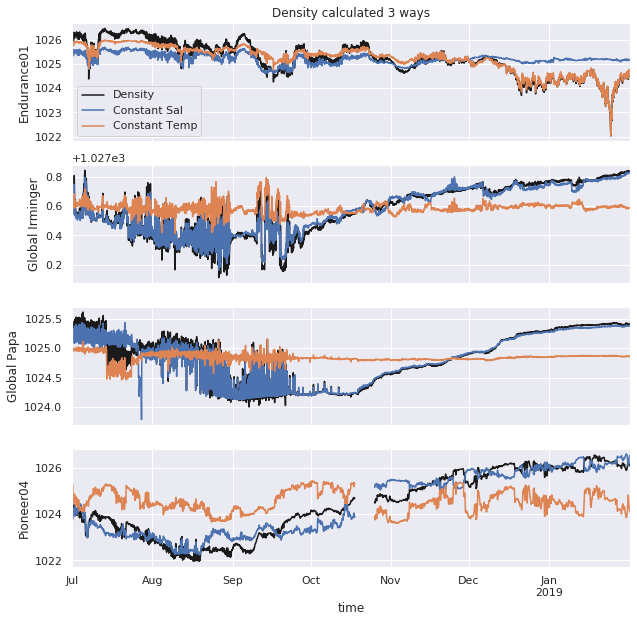

In [17]:
# Let's plot all the Densities
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharex=True,figsize=(10,10))
data['CE01 Density'].plot(ax=ax1,label='Density',color='k')
data['CE01 DenCS'].plot(ax=ax1,label='Constant Sal')
data['CE01 DenCT'].plot(ax=ax1,label='Constant Temp')
ax1.set_ylabel('Endurance01')

data['GI Density'].plot(ax=ax2,label='Density',color='k')
data['GI DenCS'].plot(ax=ax2,label='Constant Sal')
data['GI DenCT'].plot(ax=ax2,label='Constant Temp')
ax2.set_ylabel('Global Irminger')

data['GP Density'].plot(ax=ax3,label='Density',color='k')
data['GP DenCS'].plot(ax=ax3,label='Constant Sal')
data['GP DenCT'].plot(ax=ax3,label='Constant Temp')
ax3.set_ylabel('Global Papa')

data['CP04 Density'].plot(ax=ax4,label='Density',color='k')
data['CP04 DenCS'].plot(ax=ax4,label='Constant Sal')
data['CP04 DenCT'].plot(ax=ax4,label='Constant Temp')
ax4.set_ylabel('Pioneer04')

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax1.legend();
ax1.set_title('Density calculated 3 ways');

fig.savefig('ctd_density.png')

In [0]:
# Export to CSV
data.to_csv('density.csv')

## Questions
* At the workshop you presented data from fall 2016 (for the global sites) and winter/spring 2016 for Endurance.  I chose more recent 2018 data above as students seem to prefer that.  We could update this with fall 2019 data in a few months.
* Was there a prefered Endurance site?  The notes said Oregon inshore, but the specified code was for the Washington Inshore site.
  * [CE01 Oregon Inshore](https://ooi-visualocean.whoi.edu/instruments/stats-monthly/CE01ISSM-RID16-03-CTDBPC000)
  * [CE06 Washington Inshore](https://ooi-visualocean.whoi.edu/instruments/stats-monthly/CE06ISSM-RID16-03-CTDBPC000)
* Is houly averaging ok?
* For the density calculations, I used the record-mean salinities and temperatures as the constant values.
* Do you need any calculations of mean/variance for these datasets?  Students could always calculate them from the data file.
